# Wildfire and Respiratory Health Analysis

## Project Overview
This project explores the relationship between wildfire smoke, air quality, and respiratory hospital visits in Renton, Washington. The goal is to understand historical trends, uncover key patterns, and predict future impacts. The analysis combines multiple datasets, implements statistical and machine learning models, and provides actionable insights.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

## Load and Inspect Data

The data includes:

Hospital Visits: Information on respiratory-related hospitalizations.

Wildfire Smoke: Annual smoke estimates by year.

Air Quality Index (AQI): Yearly air quality data.

In [64]:
data_dir = '../Data/'
output_dir = '../Intermediate output/'
results_dir = '../Results/'

combined_df = pd.read_csv(data_dir + 'filtered_combined.csv', low_memory=False)

hospital_data = combined_df
df_smoke = pd.read_csv(output_dir + 'annual_smoke_estimate.csv')
df_aqi = pd.read_csv(output_dir + 'aqi_data.csv')
df_fire = pd.read_csv(output_dir + 'fire_data_filtered.csv')

In [ ]:


# Print previews to confirm successful loading
print("Hospital Data:")
print(hospital_data.head())
print("\nAnnual Smoke Estimate Data:")
print(df_smoke.head())
print("\nAir Quality Data:")
print(df_aqi.head())
print("\nFiltered Fire Data:")
print(df_fire.head())


In [ ]:
# Hospital data
print("Hospital Data Schema:")
print(hospital_data.dtypes)

# Annual smoke estimate data
print("Annual Smoke Estimate Data Schema:")
print(df_smoke.dtypes)

# Air quality data
print("Air Quality Data Schema:")
print(df_aqi.dtypes)

# Filtered fire data
print("Filtered Fire Data Schema:")
print(df_fire.dtypes)


# Exploring hospital data

Matplotlib is building the font cache; this may take a moment.


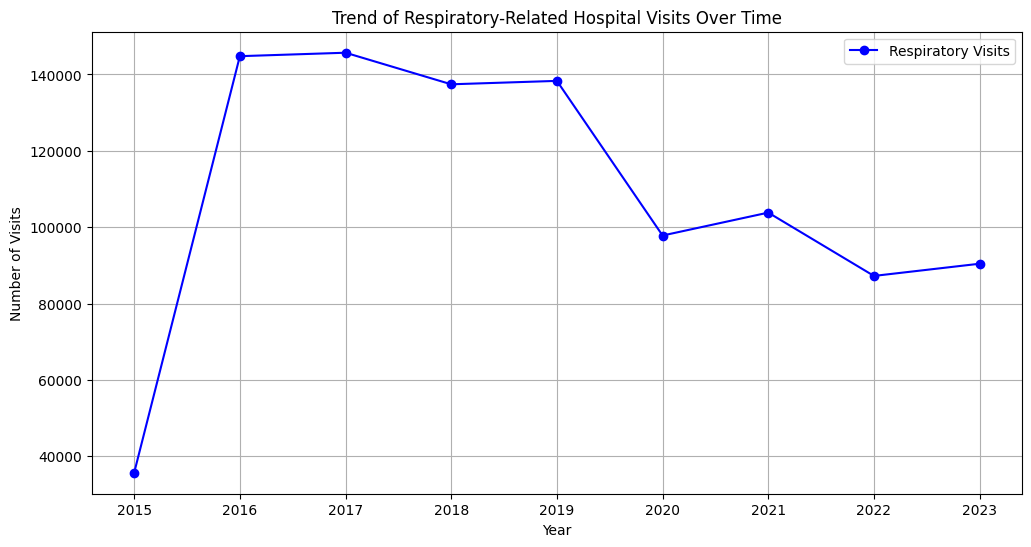

In [12]:
import matplotlib.pyplot as plt

# Define the list of relevant ICD-10 codes
respiratory_icd10_codes = [
    "J18", "J43", "J44", "J45", "J47", "J69", "J96", 
    "J40", "J20", "J41", "J42", "J68"
]

# Filter the hospital data to include only rows with these ICD-10 codes
filtered_hospital_data = combined_df[combined_df['DIAG'].isin(respiratory_icd10_codes)]
filtered_hospital_data = filtered_hospital_data[filtered_hospital_data['ZIPCODE3'].astype(str).str.startswith('98')]

respiratory_visits = filtered_hospital_data.copy()

# Filter hospital data to include only respiratory-related diagnoses (DIAG starts with 'J')
#respiratory_visits = hospital_data[hospital_data['DIAG'].str.startswith('J', na=False)]

# Group data by year and count the number of visits
annual_visits = respiratory_visits.groupby('DIS_YR').size()

# Plot the trend of respiratory-related hospital visits over time
plt.figure(figsize=(12, 6))
plt.plot(annual_visits.index, annual_visits.values, marker='o', linestyle='-', color='blue', label='Respiratory Visits')

# Adding labels, title, and legend
plt.title('Trend of Respiratory-Related Hospital Visits Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Visits')
plt.legend()
plt.grid(True)
#plt.xticks(range(annual_visits.index.min(), annual_visits.index.max() + 1, 5))  # Set x-axis ticks at a 5-year interval


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, '980'),
  Text(1, 0, '982'),
  Text(2, 0, '983'),
  Text(3, 0, '981'),
  Text(4, 0, '985'),
  Text(5, 0, '986'),
  Text(6, 0, '984'),
  Text(7, 0, '989'),
  Text(8, 0, '988'),
  Text(9, 0, '980.0'),
  Text(10, 0, '982.0'),
  Text(11, 0, '983.0'),
  Text(12, 0, '981.0'),
  Text(13, 0, '985.0'),
  Text(14, 0, '986.0'),
  Text(15, 0, '984.0'),
  Text(16, 0, '989.0'),
  Text(17, 0, '988.0')])

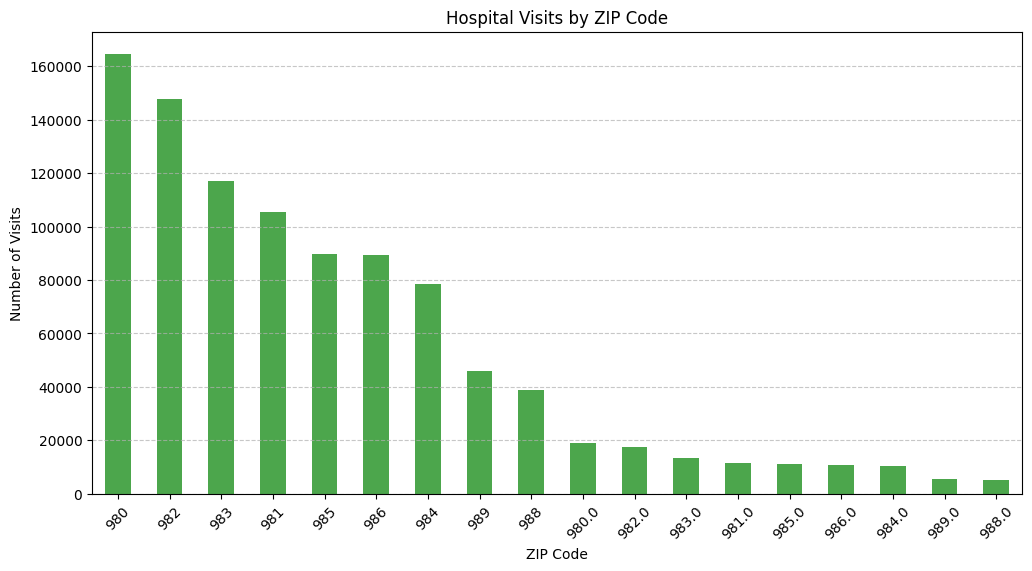

In [13]:
import matplotlib.pyplot as plt

# Group hospital data by ZIP code and count the number of visits
visits_by_zip = filtered_hospital_data.groupby('ZIPCODE3').size()

# Sort by number of visits for better visualization
visits_by_zip = visits_by_zip.sort_values(ascending=False)

# Plot the number of visits by ZIP code
plt.figure(figsize=(12, 6))
visits_by_zip.plot(kind='bar', color='green', alpha=0.7)

# Adding labels, title, and grid
plt.title('Hospital Visits by ZIP Code')
plt.xlabel('ZIP Code')
plt.ylabel('Number of Visits')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotate ZIP codes for better visibility


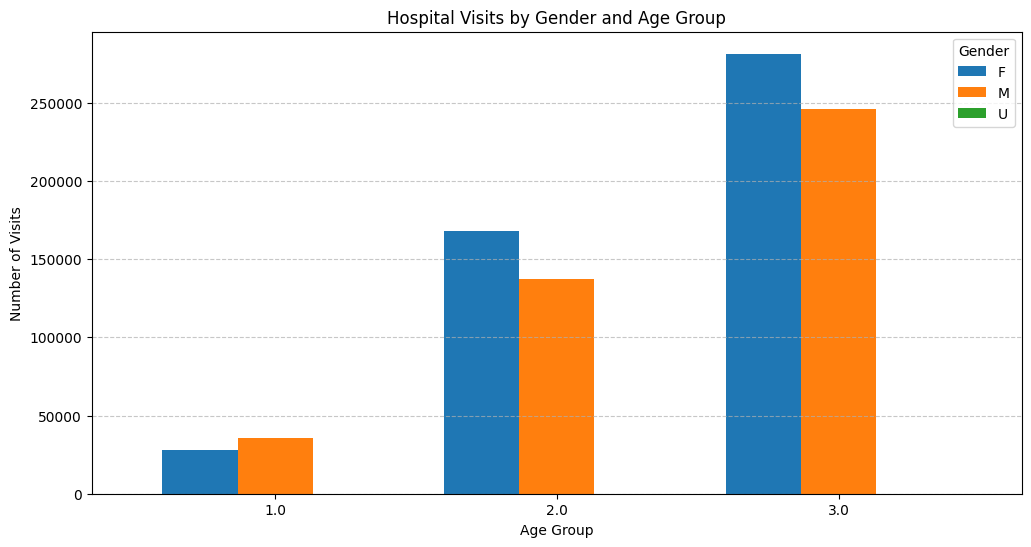

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group hospital data by AGEGROUP and SEX and count the number of visits
visits_by_age_gender = filtered_hospital_data.groupby(['AGEGROUP', 'SEX']).size().reset_index(name='Visit_Count')

# Pivot the data for easier plotting (AGEGROUP as rows, SEX as columns)
visits_pivot = visits_by_age_gender.pivot(index='AGEGROUP', columns='SEX', values='Visit_Count')

# Plot the data as a grouped bar chart
visits_pivot.plot(kind='bar', figsize=(12, 6), width=0.8)

# Adding labels, title, and legend
plt.title('Hospital Visits by Gender and Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Visits')
plt.xticks(rotation=0)  # Keep age groups horizontal for clarity
plt.legend(title='Gender', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)


Correlation Matrix:

               LOS  CHARGES1  AGEGROUP    STATUS
LOS       1.000000  0.429675  0.039242  0.141832
CHARGES1  0.429675  1.000000 -0.033217  0.058243
AGEGROUP  0.039242 -0.033217  1.000000  0.167001
STATUS    0.141832  0.058243  0.167001  1.000000


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'LOS'),
  Text(0, 1.5, 'CHARGES1'),
  Text(0, 2.5, 'AGEGROUP'),
  Text(0, 3.5, 'STATUS')])

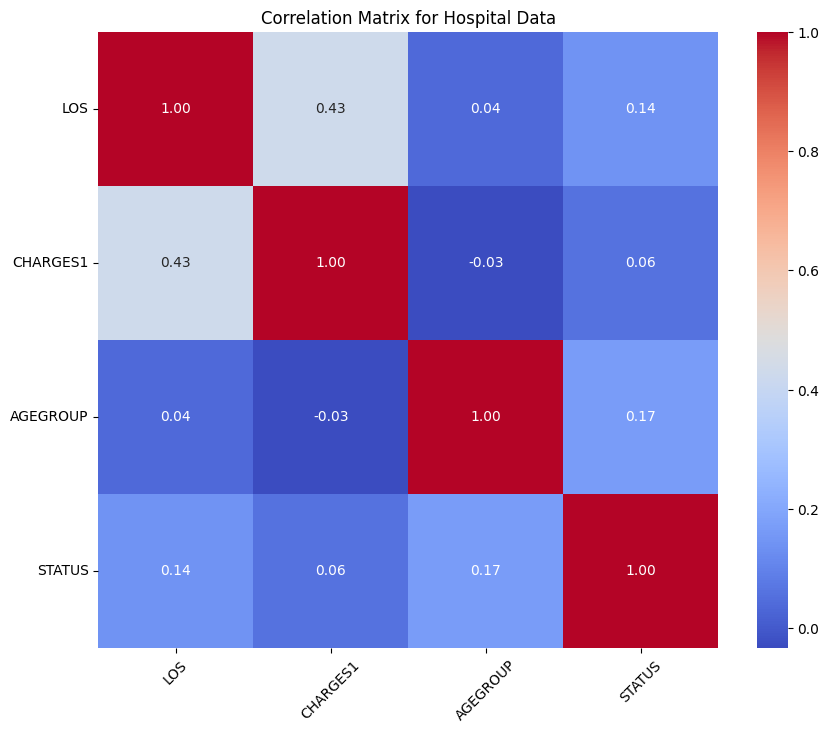

In [15]:
import seaborn as sns

# Select relevant numerical columns for correlation analysis
numerical_columns = ['LOS', 'CHARGES1', 'AGEGROUP', 'STATUS']

# Filter the hospital data to include only the selected numerical columns
numerical_data = hospital_data[numerical_columns]

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

print("Correlation Matrix:\n")
print(correlation_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)

# Adding title and labels
plt.title('Correlation Matrix for Hospital Data')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Keep y-axis labels horizontal


### Findings from the Correlation Matrix

The correlation matrix reveals the relationships between numerical variables in the hospital dataset:

| Variable Pairs | Correlation Value | Interpretation |
|-----------------|-------------------|----------------|
| **LOS and CHARGES1** | **0.43** | A moderate positive correlation exists, indicating that longer lengths of stay (LOS) tend to be associated with higher hospital charges. |
| **LOS and AGEGROUP** | **0.04** | Almost no correlation between length of stay (LOS) and the age group of the patient. |
| **LOS and STATUS** | **0.14** | A weak positive correlation, suggesting a slight relationship between LOS and the discharge status of the patient. |
| **CHARGES1 and AGEGROUP** | **-0.03** | Virtually no correlation between hospital charges and the age group of the patient. |
| **CHARGES1 and STATUS** | **0.06** | A negligible positive correlation between hospital charges and discharge status. |
| **AGEGROUP and STATUS** | **0.17** | A weak positive correlation, suggesting that older patients may have slightly different discharge statuses. |

### Insights:
1. **LOS and CHARGES1**:
   - As expected, longer hospital stays are moderately associated with higher charges.
   - This relationship might help identify cost drivers in the hospital system.

2. **AGEGROUP**:
   - Age has minimal correlation with other variables, implying that age alone does not strongly influence LOS, charges, or discharge status in this dataset.

3. **Discharge Status (STATUS)**:
   - Weak correlations with other variables indicate that the discharge outcome is influenced by factors not strongly represented in these numerical variables.

### Implications:
- The moderate correlation between **LOS and CHARGES1** could inform models predicting hospital costs based on stay duration.
- Weak or negligible correlations for other variables suggest limited direct relationships, but further analysis (e.g., interactions with categorical variables) may reveal additional insights.


# exploring smoke impact 

([<matplotlib.axis.XTick at 0x162614950>,
 [Text(1961, 0, '1961'),
  Text(1966, 0, '1966'),
  Text(1971, 0, '1971'),
  Text(1976, 0, '1976'),
  Text(1981, 0, '1981'),
  Text(1986, 0, '1986'),
  Text(1991, 0, '1991'),
  Text(1996, 0, '1996'),
  Text(2001, 0, '2001'),
  Text(2006, 0, '2006'),
  Text(2011, 0, '2011'),
  Text(2016, 0, '2016')])

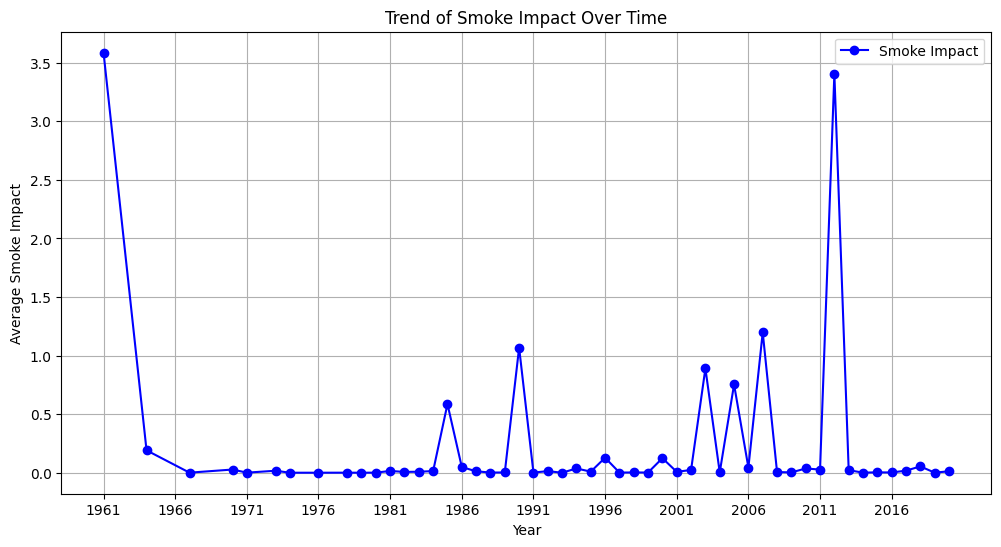

In [16]:
# Plot the trend of smoke impact over time
plt.figure(figsize=(12, 6))
plt.plot(df_smoke['Year'], df_smoke['Smoke_estimate'], marker='o', linestyle='-', color='blue', label='Smoke Impact')

# Adding labels, title, and legend
plt.title('Trend of Smoke Impact Over Time')
plt.xlabel('Year')
plt.ylabel('Average Smoke Impact')
plt.legend()
plt.grid(True)
plt.xticks(range(df_smoke['Year'].min(), df_smoke['Year'].max() + 1, 5))  # Set x-axis ticks at 5-year intervals


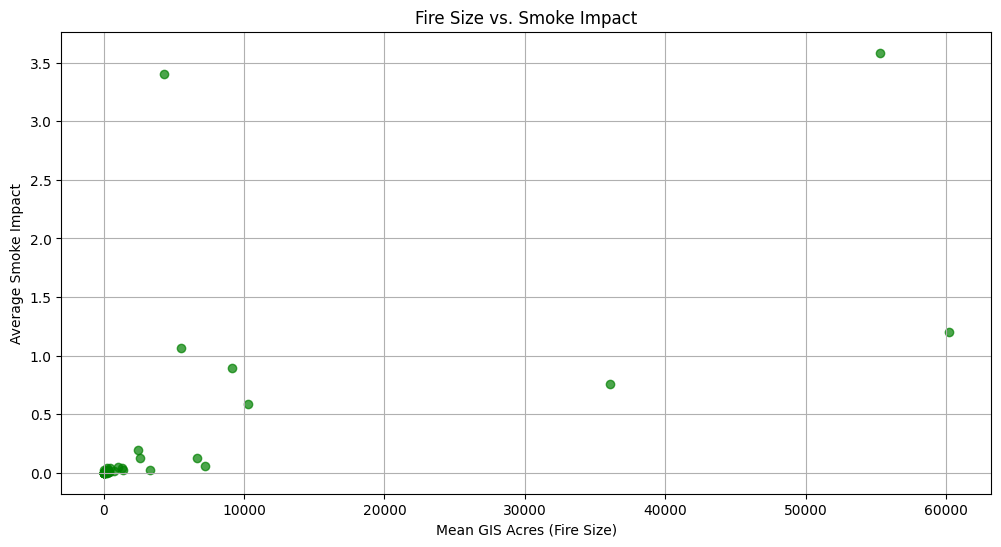

In [17]:
# Scatter plot for fire size vs. smoke impact
plt.figure(figsize=(12, 6))
plt.scatter(df_smoke['Mean_GIS_Acres'], df_smoke['Smoke_estimate'], color='green', alpha=0.7)

# Adding labels and title
plt.title('Fire Size vs. Smoke Impact')
plt.xlabel('Mean GIS Acres (Fire Size)')
plt.ylabel('Average Smoke Impact')
plt.grid(True)


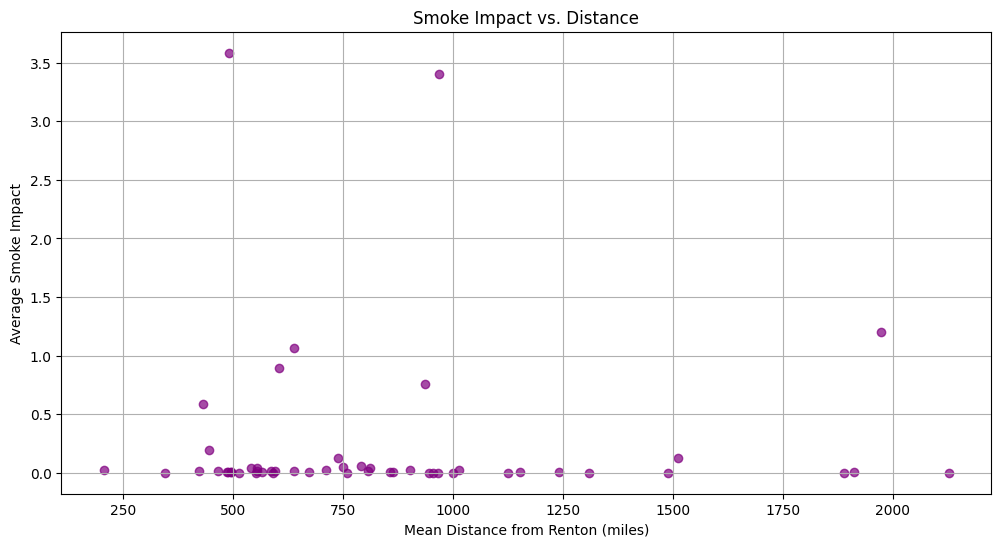

In [18]:
# Scatter plot for smoke impact vs. distance
plt.figure(figsize=(12, 6))
plt.scatter(df_smoke['Mean_Distance'], df_smoke['Smoke_estimate'], color='purple', alpha=0.7)

# Adding labels and title
plt.title('Smoke Impact vs. Distance')
plt.xlabel('Mean Distance from Renton (miles)')
plt.ylabel('Average Smoke Impact')
plt.grid(True)


# exploring Air Quality Data

([<matplotlib.axis.XTick at 0x162428e30>,
 [Text(1999, 0, '1999'),
  Text(2004, 0, '2004'),
  Text(2009, 0, '2009'),
  Text(2014, 0, '2014'),
  Text(2019, 0, '2019')])

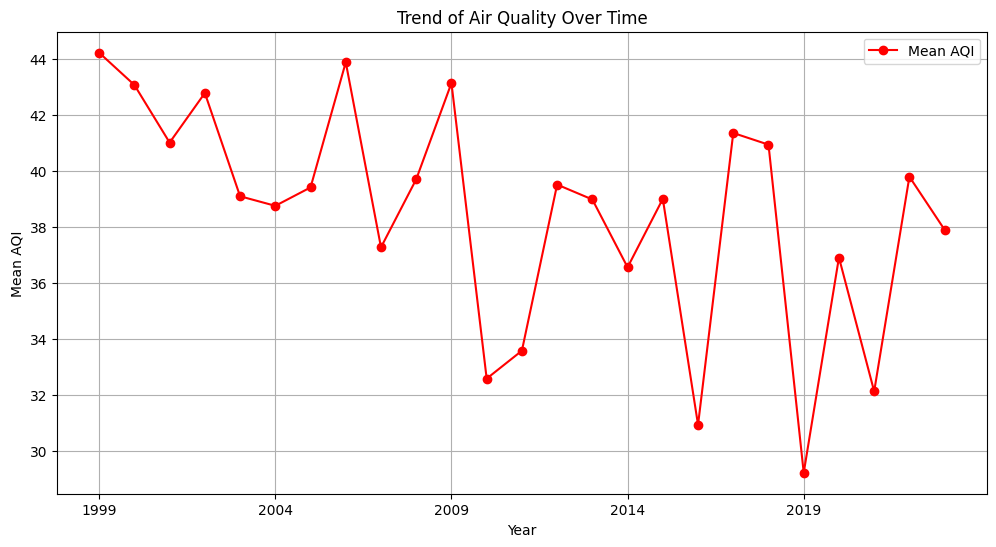

In [19]:


# Plot the trend of mean AQI over time
plt.figure(figsize=(12, 6))
plt.plot(df_aqi['Year'], df_aqi['mean_AQI'], marker='o', linestyle='-', color='red', label='Mean AQI')

# Adding labels, title, and legend
plt.title('Trend of Air Quality Over Time')
plt.xlabel('Year')
plt.ylabel('Mean AQI')
plt.legend()
plt.grid(True)
plt.xticks(range(df_aqi['Year'].min(), df_aqi['Year'].max() + 1, 5))  # Set x-axis ticks at 5-year intervals

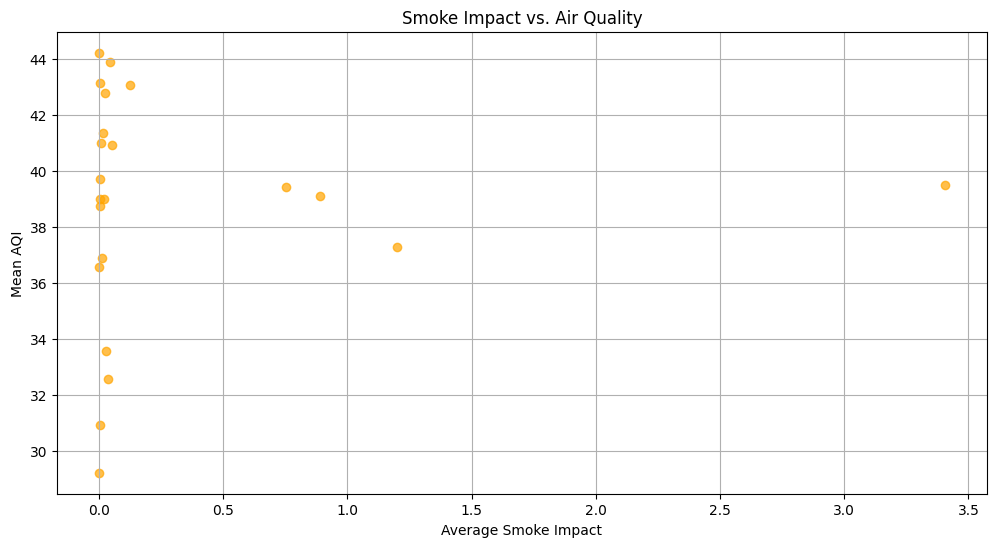

In [20]:
# Merge df_smoke and df_aqi on Year
combined_data = pd.merge(df_smoke, df_aqi, on='Year', how='inner')

# Scatter plot for smoke impact vs. air quality
plt.figure(figsize=(12, 6))
plt.scatter(combined_data['Smoke_estimate'], combined_data['mean_AQI'], color='orange', alpha=0.7)

# Adding labels and title
plt.title('Smoke Impact vs. Air Quality')
plt.xlabel('Average Smoke Impact')
plt.ylabel('Mean AQI')
plt.grid(True)


In [21]:
# Calculate the Pearson correlation between Smoke_estimate and mean_AQI
correlation = combined_data['Smoke_estimate'].corr(combined_data['mean_AQI'])

# Print the correlation result
print(f"Pearson Correlation between Smoke Impact and Mean AQI: {correlation}")

Pearson Correlation between Smoke Impact and Mean AQI: 0.03715331720295568


In [22]:
kendall_corr = combined_data['Smoke_estimate'].corr(combined_data['mean_AQI'], method='kendall')
spearman_corr = combined_data['Smoke_estimate'].corr(combined_data['mean_AQI'], method='spearman')
print(f"Kendall Correlation: {kendall_corr}")
print(f"Spearman Correlation: {spearman_corr}")


Kendall Correlation: 0.11688311688311688
Spearman Correlation: 0.17334839073969513


In [23]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(combined_data['Smoke_estimate'], combined_data['mean_AQI'])
print(f"Pearson Correlation: {corr}, P-value: {p_value}")


Pearson Correlation: 0.037153317202955685, P-value: 0.869614287661651


# Exploring Fire Data

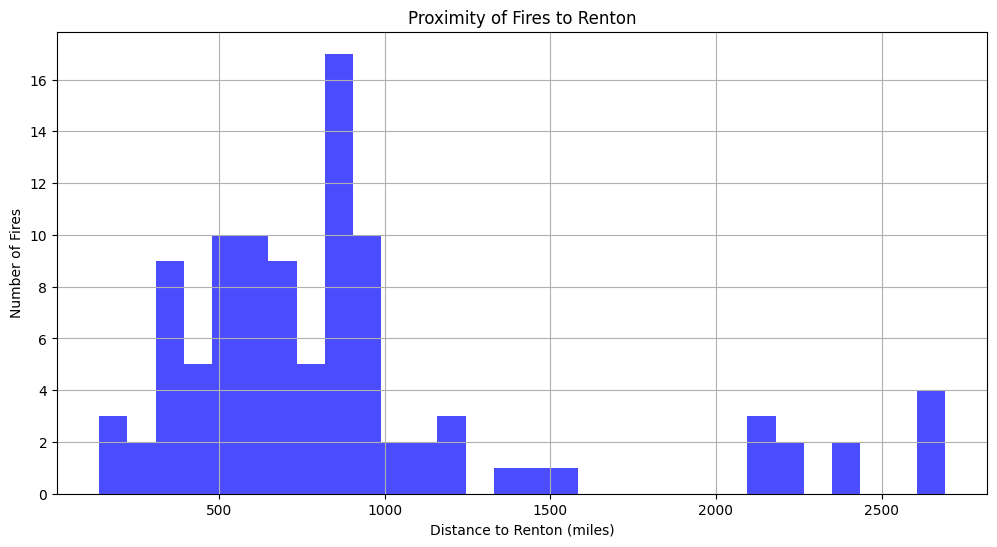

In [24]:
# Plot a histogram of fire distances from Renton
plt.figure(figsize=(12, 6))
plt.hist(df_fire['shortest_distance_to_renton'], bins=30, color='blue', alpha=0.7)

# Adding labels and title
plt.title('Proximity of Fires to Renton')
plt.xlabel('Distance to Renton (miles)')
plt.ylabel('Number of Fires')
plt.grid(True)


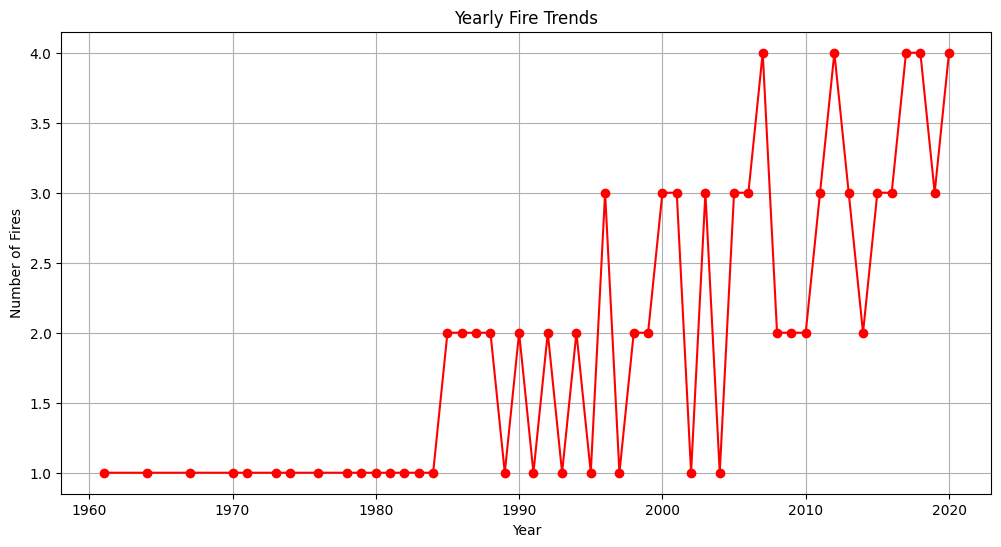

In [25]:
# Group data by year and count the number of fires
fires_per_year = df_fire.groupby('attributes_Fire_Year').size()

# Plot the trend of fire counts over time
plt.figure(figsize=(12, 6))
fires_per_year.plot(kind='line', marker='o', linestyle='-', color='red')

# Adding labels and title
plt.title('Yearly Fire Trends')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(True)
#plt.xticks(range(fires_per_year.index.min(), fires_per_year.index.max() + 1, 5))  # Set x-axis ticks at 5-year intervals


# Exploring Relationships between hospital visits, smoke impact and air quality

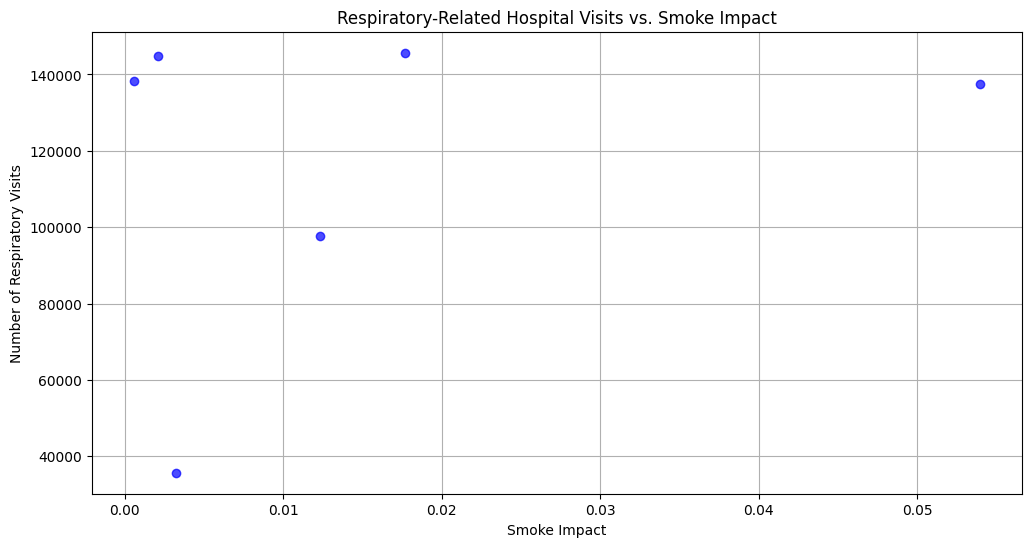

In [26]:
# Merge hospital data (grouped by year) with smoke estimate data
hospital_visits_by_year = filtered_hospital_data.groupby('DIS_YR').size().reset_index(name='Respiratory_Visits')
combined_smoke_visits = pd.merge(hospital_visits_by_year, df_smoke, left_on='DIS_YR', right_on='Year', how='inner')

# Plot respiratory visits vs. smoke impact
plt.figure(figsize=(12, 6))
plt.scatter(combined_smoke_visits['Smoke_estimate'], combined_smoke_visits['Respiratory_Visits'], color='blue', alpha=0.7)

# Adding labels and title
plt.title('Respiratory-Related Hospital Visits vs. Smoke Impact')
plt.xlabel('Smoke Impact')
plt.ylabel('Number of Respiratory Visits')
plt.grid(True)


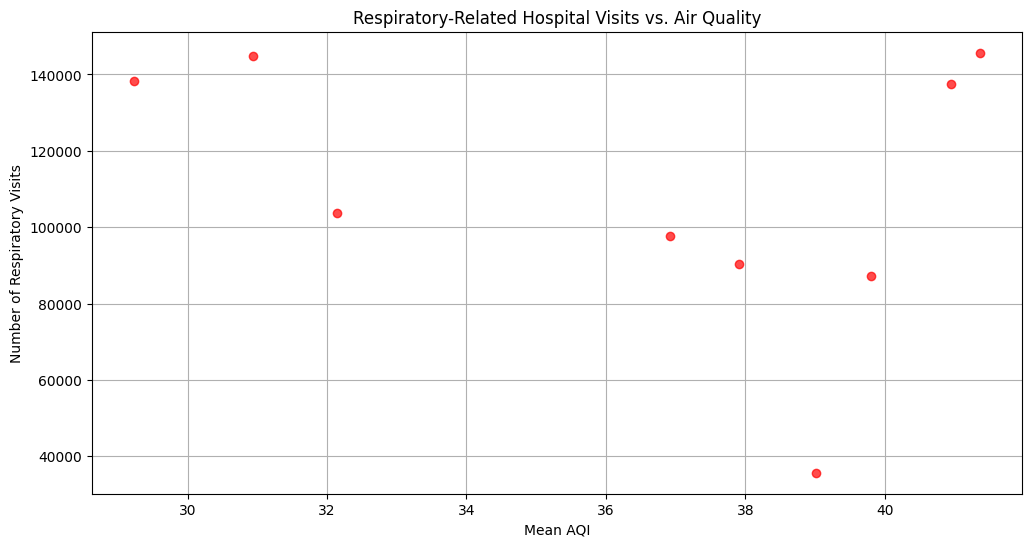

In [28]:
# Merge hospital data (grouped by year) with air quality data
combined_visits_aqi = pd.merge(hospital_visits_by_year, df_aqi, left_on='DIS_YR', right_on='Year', how='inner')

# Plot respiratory visits vs. air quality
plt.figure(figsize=(12, 6))
plt.scatter(combined_visits_aqi['mean_AQI'], combined_visits_aqi['Respiratory_Visits'], color='red', alpha=0.7)

# Adding labels and title
plt.title('Respiratory-Related Hospital Visits vs. Air Quality')
plt.xlabel('Mean AQI')
plt.ylabel('Number of Respiratory Visits')
plt.grid(True)


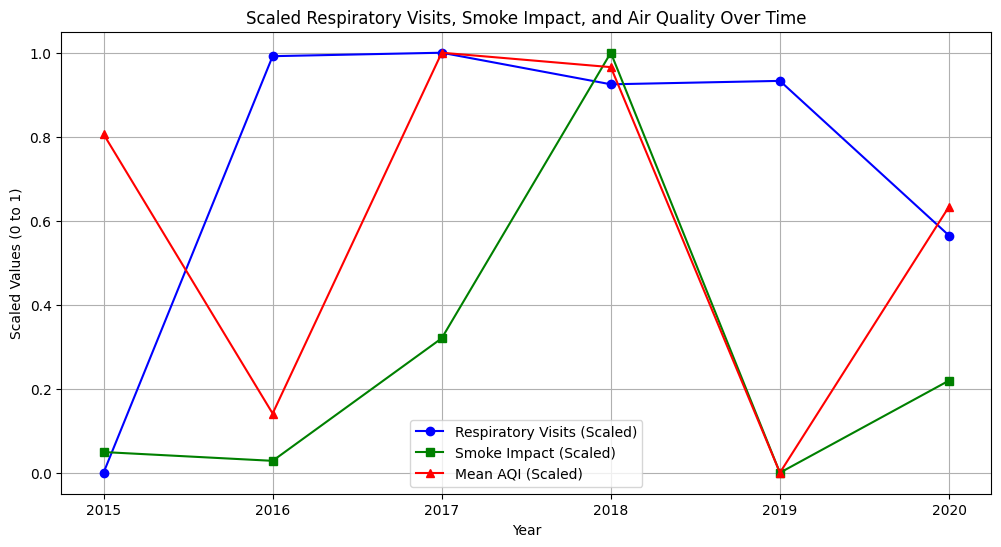

In [36]:
from sklearn.preprocessing import MinMaxScaler

# Merge smoke impact, air quality, and hospital visits into a single DataFrame
combined_all = pd.merge(combined_smoke_visits, df_aqi, left_on='Year', right_on='Year', how='inner')

# Initialize Min-Max Scaler
scaler = MinMaxScaler()

# Select columns to scale and apply scaling
scaled_columns = ['Respiratory_Visits', 'Smoke_estimate', 'mean_AQI']
combined_all[scaled_columns] = scaler.fit_transform(combined_all[scaled_columns])

# Plot all three variables over time
plt.figure(figsize=(12, 6))
plt.plot(combined_all['Year'], combined_all['Respiratory_Visits'], marker='o', label='Respiratory Visits (Scaled)', color='blue')
plt.plot(combined_all['Year'], combined_all['Smoke_estimate'], marker='s', label='Smoke Impact (Scaled)', color='green')
plt.plot(combined_all['Year'], combined_all['mean_AQI'], marker='^', label='Mean AQI (Scaled)', color='red')

# Adding labels, title, and legend
plt.title('Scaled Respiratory Visits, Smoke Impact, and Air Quality Over Time')
plt.xlabel('Year')
plt.ylabel('Scaled Values (0 to 1)')
plt.legend()
plt.grid(True)

In [37]:
correlation_results = combined_all.drop(columns=['Year']).corr(method='pearson')

print('Correlation Matrix:')
print(correlation_results)

corr_acres_visit, p_acres_visits = pearsonr(combined_all['Mean_GIS_Acres'], combined_all['Respiratory_Visits'])
corr_aqi_visits, p_aqi_visits = pearsonr(combined_all['mean_AQI'], combined_all['Respiratory_Visits'])
corr_acres_aqi, p_acres_aqi = pearsonr(combined_all['Mean_GIS_Acres'], combined_all['mean_AQI'])

print(f"Correlation between Total_Burned_Acres and Respiratory_Visits: {corr_acres_visit:.2f} (p-value: {p_acres_visits:.2e})")
print(f"Correlation between Average_AQI and Respiratory_Visits: {corr_aqi_visits:.2f} (p-value: {p_aqi_visits:.2e})")
print(f"Correlation between Total_Burned_Acres and Average_AQI: {corr_acres_aqi:.2f} (p-value: {p_acres_aqi:.2e})")

Correlation Matrix:
                      DIS_YR  Respiratory_Visits  Smoke_estimate  \
DIS_YR              1.000000            0.347963        0.203921   
Respiratory_Visits  0.347963            1.000000        0.276822   
Smoke_estimate      0.203921            0.276822        1.000000   
Mean_GIS_Acres      0.140593            0.270972        0.965490   
Mean_Distance       0.357043            0.597114       -0.194682   
mean_AQI           -0.165675           -0.259436        0.635151   

                    Mean_GIS_Acres  Mean_Distance  mean_AQI  
DIS_YR                    0.140593       0.357043 -0.165675  
Respiratory_Visits        0.270972       0.597114 -0.259436  
Smoke_estimate            0.965490      -0.194682  0.635151  
Mean_GIS_Acres            1.000000      -0.067467  0.476269  
Mean_Distance            -0.067467       1.000000 -0.684776  
mean_AQI                  0.476269      -0.684776  1.000000  
Correlation between Total_Burned_Acres and Respiratory_Visits: 0.27 (

### Statistical Significance of Correlations

Total Burned Acres vs. Respiratory Visits:

Correlation: 0.27, p-value: 0.60
The high p-value indicates that the correlation is not statistically significant, and the observed relationship could easily occur by chance.

AQI vs. Respiratory Visits:
Correlation: -0.26, p-value: 0.62
Similar to above, the high p-value suggests no statistically meaningful relationship.

Total Burned Acres vs. AQI:
Correlation: 0.48, p-value: 0.34
Although the correlation is stronger, the high p-value still indicates a lack of statistical significance.

### Combined Dataset Insights (2015–2020)

Smoke Impact Peaks:

Smoke impact is highest in 2018 (Smoke_estimate = 1.0), likely driven by a large fire size (Mean_GIS_Acres = 7222.9) and proximity to Renton.

This coincides with high respiratory visits and AQI values, suggesting a potential relationship.

2019 Exception:

In 2019, there is no smoke impact (Smoke_estimate = 0) and the AQI is very low (mean_AQI = 0), yet respiratory visits remain high. This highlights possible external factors affecting hospital visits that are unrelated to smoke or air quality.

2020 Patterns:
In 2020, moderate smoke impact (Smoke_estimate = 0.22) and AQI (mean_AQI = 0.63) coincide with fewer respiratory visits compared to prior years.

# ARIMA model

Prepared Data:
   DIS_YR  Respiratory_Visits  Log_Respiratory_Visits
0    2015               35690               10.482654
1    2016              144780               11.882978
2    2017              145685               11.889209
3    2018              137415               11.830768
4    2019              138310               11.837260
5    2020               97810               11.490792
6    2021              103812               11.550346
7    2022               87230               11.376315
8    2023               90425               11.412287
Target Variable (Log-Transformed):
0    10.482654
1    11.882978
2    11.889209
3    11.830768
4    11.837260
5    11.490792
6    11.550346
7    11.376315
8    11.412287
Name: Log_Respiratory_Visits, dtype: float64
p: 0, d: 0, q: 0, Valid Folds: 3, RMSE: 0.3850915981177036
p: 0, d: 0, q: 1, Valid Folds: 3, RMSE: 0.3759520836736559
p: 0, d: 0, q: 2, Valid Folds: 3, RMSE: 0.38041894493233547
p: 0, d: 0, q: 3, Valid Folds: 3, RMSE: 0.3494146953

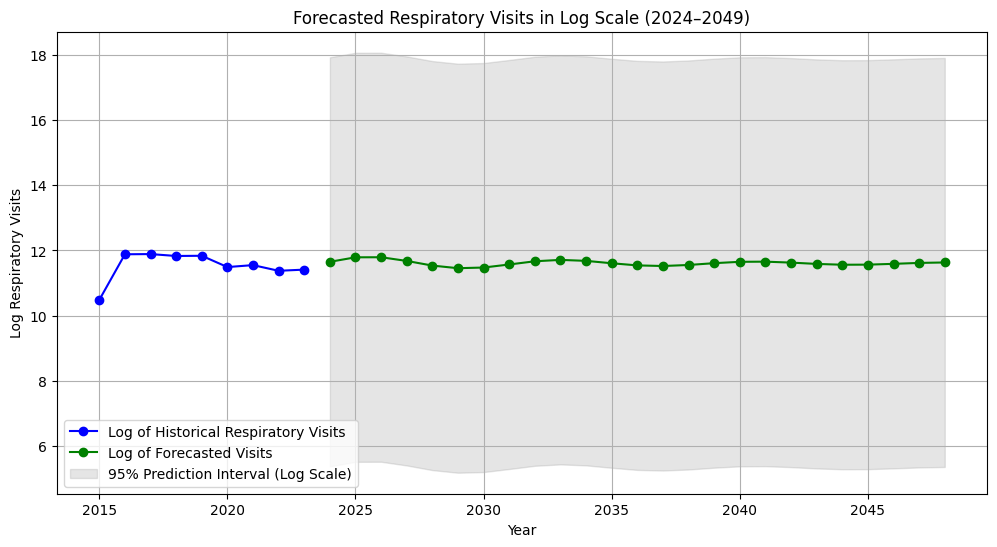

In [71]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
respiratory_data = hospital_visits_by_year[['DIS_YR', 'Respiratory_Visits']].copy()
respiratory_data.dropna(inplace=True)
respiratory_data.sort_values(by='DIS_YR', inplace=True)

# Log-transform the target variable to stabilize variance
respiratory_data['Log_Respiratory_Visits'] = np.log1p(respiratory_data['Respiratory_Visits'])
target_variable = respiratory_data['Log_Respiratory_Visits']

# Debugging: Check the data and target variable
print("Prepared Data:")
print(respiratory_data)
print("Target Variable (Log-Transformed):")
print(target_variable)

# Define parameter ranges for grid search
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)
best_rmse = float('inf')
best_order = None

# Function to fit ARIMA and calculate RMSE
def fit_arima_and_calculate_rmse(train_data, test_data, order):
    """
    Fit ARIMA model and calculate RMSE for the given order.
    Args:
        train_data (pd.Series): Training data for ARIMA.
        test_data (pd.Series): Test data for RMSE calculation.
        order (tuple): The ARIMA order (p, d, q).
    Returns:
        float: RMSE for the given ARIMA order.
    """
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test_data))
        rmse = sqrt(mean_squared_error(test_data, forecast))
        return rmse
    except Exception as e:
        print(f"ARIMA order {order} failed: {e}")
        return float('inf')

# Grid search
num_folds = 3
fold_size = len(target_variable) // num_folds
for p in p_values:
    for d in d_values:
        for q in q_values:
            rmse_sum = 0
            valid_folds = 0
            for i in range(num_folds):
                start_idx = i * fold_size
                end_idx = (i + 1) * fold_size
                test_fold = target_variable.iloc[start_idx:end_idx]
                train_fold = pd.concat([target_variable.iloc[:start_idx], target_variable.iloc[end_idx:]])
                if len(train_fold) < 3 or len(test_fold) < 1:
                    continue
                rmse_fold = fit_arima_and_calculate_rmse(train_fold, test_fold, order=(p, d, q))
                if rmse_fold < float('inf'):
                    rmse_sum += rmse_fold
                    valid_folds += 1
            if valid_folds > 0:
                avg_rmse = rmse_sum / valid_folds
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_order = (p, d, q)
                print(f'p: {p}, d: {d}, q: {q}, Valid Folds: {valid_folds}, RMSE: {avg_rmse}')
            else:
                print(f'p: {p}, d: {d}, q: {q} skipped due to insufficient data')

print(f"Best ARIMA order: {best_order}")
print(f"Best average RMSE: {best_rmse}")

# Fit the best ARIMA model
model = ARIMA(target_variable, order=best_order)
model_fit = model.fit()

# Debugging: Print the model summary
print(model_fit.summary())

# Forecast future values
forecast_steps = 25  # Predicting 25 years into the future
forecast = model_fit.forecast(steps=forecast_steps)
residuals = model_fit.resid

# Calculate confidence intervals
stderr = np.std(residuals)
conf_int = np.column_stack((forecast - stderr * 1.96, forecast + stderr * 1.96))

# Convert forecast and intervals back to the original scale
forecast_original_scale = np.expm1(forecast)
conf_int_original_scale = np.expm1(conf_int)

# Create a DataFrame for forecasted values
forecast_years = range(respiratory_data['DIS_YR'].max() + 1, respiratory_data['DIS_YR'].max() + 1 + forecast_steps)
forecasted_data = pd.DataFrame({
    'Year': forecast_years,
    'Forecasted_Respiratory_Visits': forecast_original_scale,
    'Lower_Bound': conf_int_original_scale[:, 0],
    'Upper_Bound': conf_int_original_scale[:, 1]
})

# Debugging: Check the forecasted data
print("Forecasted Data:")
print(forecasted_data)

# Historical data in log scale
plt.figure(figsize=(12, 6))
plt.plot(respiratory_data['DIS_YR'], target_variable, label='Log of Historical Respiratory Visits', marker='o', color='blue')

# Forecasted data in log scale
plt.plot(forecasted_data['Year'], forecast, label='Log of Forecasted Visits', marker='o', color='green')

# Confidence intervals in log scale
plt.fill_between(
    forecasted_data['Year'],
    conf_int[:, 0],
    conf_int[:, 1],
    color='gray', alpha=0.2, label='95% Prediction Interval (Log Scale)'
)

plt.xlabel('Year')
plt.ylabel('Log Respiratory Visits')
plt.title('Forecasted Respiratory Visits in Log Scale (2024–2049)')
plt.legend()
plt.grid(True)
plt.show()


ADF Statistic: -0.8470787204530638
p-value: 0.8049005577737057
Critical Values:
	1%: -4.9386902332361515
	5%: -3.477582857142857
	10%: -2.8438679591836733
RUNNING THE L-BFGS-B CODE

           * * *
SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:71.55886098143095

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86438D+00    |proj g|=  7.51399D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.514D-08   3.864D+00
  F =   3.8643811656350531     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGT

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86477D+00    |proj g|=  9.34958D-01

At iterate    5    f=  3.34747D+00    |proj g|=  6.51594D-03

At iterate   10    f=  3.34590D+00    |proj g|=  5.12460D-03

At iterate   15    f=  3.34518D+00    |proj g|=  1.31755D-03

At iterate   20    f=  3.34507D+00    |proj g|=  9.80525D-04

At iterate   25    f=  3.34501D+00    |proj g|=  5.11239D-04

At iterate   30    f=  3.34498D+00    |proj g|=  2.25511D-04

At iterate   35    f=  3.34497D+00    |proj g|=  2.67524D-04

At iterate   40    f=  3.34497D+00    |proj g|=  3.81942D-05

At iterate   45    f=  3.34497D+00    |proj g|=  1.03973D-04

At iterate   50    f=  3.34497D+00    |proj g|=  1.56453D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:68.20951442966188
At iterate   20    f=  3.34499D+00    |proj g|=  3.13331D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   2.020D-06   3.345D+00
  F =   3.3449730238701050     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.89454D+00    |proj g|=  3.50689D-03

At iterate   15    f=  2.89309D+00    |proj g|=  2.45458D-04

At iterate   20    f=  2.89285D+00    |proj g|=  2.35584D-04

At iterate   25    f=  2.89282D+00    |proj g|=  3.08824D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     37      1     0     0   8.840D-06   2.893D+00
  F =   2.8928189420021555     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(0, 0, 2)x(1, 0, 1, 12) - AIC:62.0707409560388
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43965D+00    |proj g|=  2.68869D+01

At iterate    5    f=  6.70467D-01    |proj g|=  2.12744D-03

At iterate   10    f=  6.70452D-01    |proj g|=  2.00820D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     35      1     0     0   2.530D-05   6.705D-01
  F =  0.67045233118943648     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:16.068141961409857
RUNNING THE L-B

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   20    f=  6.25427D-01    |proj g|=  7.31746D-03

At iterate   25    f=  6.25424D-01    |proj g|=  3.05385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     58      1     0     0   7.794D-05   6.254D-01
  F =  0.62542363532185474     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(0, 1, 2)x(0, 0, 1, 12) - AIC:19.257625435793386
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     35      1     0     0   8.307D-06   1.094D+00
  F =   1.0940640010797826     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:25.693152019436088
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explore

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:27.444788809198464
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=          NaN
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=          NaN
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40347D+02    |proj g|=  2.67509D+03

At iterate    5    f=  1.51981D+00    |proj g|=  4.90748D-01

At iterate   10    f=  1.13921D+00    |proj g|=  5.89531D-02

At iterate   15    f=  1.12215D+00    |proj g|=  9.49928D-02
SARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:25.992267080705748

At iterate   20 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.51929D+00    |proj g|=  5.33507D-01

At iterate   10    f=  1.12429D+00    |proj g|=  6.46358D-02

At iterate   15    f=  1.11640D+00    |proj g|=  8.62033D-02

At iterate   20    f=  1.11073D+00    |proj g|=  8.01405D-03

At iterate   25    f=  1.11023D+00    |proj g|=  3.98254D-03

At iterate   30    f=  1.11011D+00    |proj g|=  5.88255D-03

At iterate   35    f=  1.10883D+00    |proj g|=  9.01855D-03

At iterate   40    f=  1.10874D+00    |proj g|=  1.46735D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     64      1     0     0   1.467D-04   1.109D+00
  F =   1.10873683345

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  1.21686D+00    |proj g|=  4.42111D-01

At iterate   40    f=  1.11322D+00    |proj g|=  1.50500D-01

At iterate   45    f=  1.08685D+00    |proj g|=  1.42665D-02

At iterate   50    f=  1.08672D+00    |proj g|=  7.40481D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   7.405D-04   1.087D+00
  F =   1.0867187571760994     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
SARIMA(1, 0, 2)x(0, 0, 1, 12) - AIC:29.56093762916979
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(1, 0, 2)x(1, 1, 0, 12) - AIC:10.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA(1, 0, 2)x(1, 1, 1, 12) - AIC:12.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  6.23056D-01    |proj g|=  1.68665D-04

At iterate   30    f=  6.23019D-01    |proj g|=  7.09736D-03

At iterate   35    f=  6.22972D-01    |proj g|=  2.44166D-03

At iterate   40    f=  6.22959D-01    |proj g|=  9.13266D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     89      1     0     0   1.694D-03   6.230D-01
  F =  0.62295683531419377     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(1, 1, 2)x(0, 0, 1, 12) - AIC:21.21322303565549
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate    5    f=  1.14142D+00    |proj g|=  1.95760D-01

At iterate   10    f=  1.12392D+00    |proj g|=  4.42427D-02

At iterate   15    f=  1.09610D+00    |proj g|=  1.43098D-01

At iterate   20    f=  1.09397D+00    |proj g|=  2.49384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   1.943D-05   1.094D+00
  F =   1.0939644392353733     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 0, 0)x(0, 0, 1, 12) - AIC:27.69135990623672
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  1.07947D+00    |proj g|=  1.24275D-01

At iterate   45    f=  1.07807D+00    |proj g|=  3.77519D-01

At iterate   50    f=  1.07712D+00    |proj g|=  1.39220D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68      1     0     0   1.392D-01   1.077D+00
  F =   1.0771198050999395     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
SARIMA(2, 0, 0)x(1, 0, 1, 12) - AIC:29.388156491798913
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  1.06256D+00    |proj g|=  1.85944D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   1.859D-03   1.063D+00
  F =   1.0625556532911231     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
SARIMA(2, 0, 1)x(0, 0, 1, 12) - AIC:29.126001759240214
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00873D+09    |proj g|=  1.50655D+14

At iterate    5    f=  2.98627D+02    |proj g|=  2.32288D+04

At iterate   10    f=  3.97089D+01    |proj g|=  1.16489D+03
SARIMA(2, 0, 2)x(0, 0, 0, 12) - AIC:29.17826205251054

At iterate   15    f=  5.22572D+00    |proj g|=  5.63526D+01

At iterate   20    f=  1.31278D+00    |proj g|=  2.05655D+00

At iterate   25    f=  1.15364D+00    |proj g|=  1.21995D-01

At iterate   30    f=  1.10816D+00    |proj g|=  5.30219D-01

At iterate   35    f=  1.08577D+00    |proj g|=  5.19118D-02

At iterate   40    f=  1.07057D+00    |proj g|=  1.51390D-02

At iterate   45    f=  1.06579D+00    |proj g|=  7.45942D-03

At iterate   50    f=  1.06546D+00    |proj g|=  1.12816D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.98584D+02    |proj g|=  2.32261D+04

At iterate   10    f=  3.96386D+01    |proj g|=  1.16329D+03

At iterate   15    f=  5.14915D+00    |proj g|=  5.56940D+01

At iterate   20    f=  1.25959D+00    |proj g|=  1.84276D+00

At iterate   25    f=  1.12653D+00    |proj g|=  1.54793D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     61      1     0     0   2.184D-01   1.090D+00
  F =   1.0902369606093227     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 0, 2)x(1, 0, 1, 12) - AIC:33.62426529096781
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


SARIMA(2, 1, 0)x(1, 0, 1, 12) - AIC:22.068270254880545RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92650D+00    |proj g|=  5.47715D+01

At iterate    5    f=  6.72473D-01    |proj g|=  4.46374D-02

At iterate   10    f=  6.70460D-01    |proj g|=  1.66431D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     25      1     0     0   2.855D-05   6.705D-01
  F =  0.67045945860447476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

RUNNING THE L-B


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  6.43918D-01    |proj g|=  8.83629D-03

At iterate   35    f=  6.43772D-01    |proj g|=  8.83280D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     61      1     0     0   7.546D-04   6.438D-01
  F =  0.64376105562933972     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA(2, 1, 1)x(1, 0, 1, 12) - AIC:23.587699001328115
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * *

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  6.12949D-01    |proj g|=  1.68567D-03

At iterate   50    f=  6.12892D-01    |proj g|=  2.86237D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     71      1     0     0   2.862D-03   6.129D-01
  F =  0.61289171553940391     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
SARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:23.03205087970927
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09674D-01    |proj g|=  1.20849D-01

At iterate    5

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


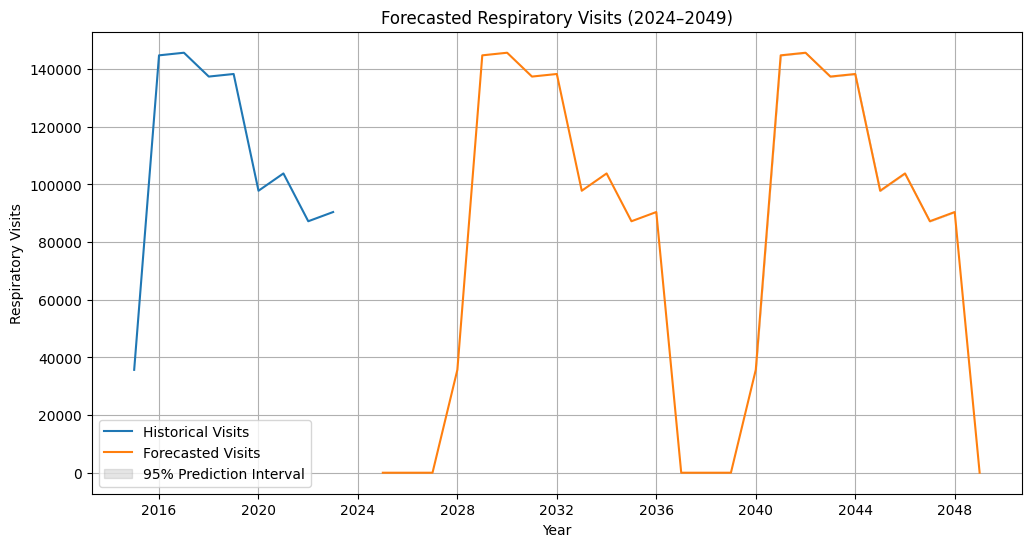

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Prepare the data
respiratory_data = hospital_visits_by_year[['DIS_YR', 'Respiratory_Visits']].copy()
respiratory_data.dropna(inplace=True)
respiratory_data.sort_values(by='DIS_YR', inplace=True)
respiratory_data['DIS_YR'] = pd.to_datetime(respiratory_data['DIS_YR'], format='%Y')
respiratory_data.set_index('DIS_YR', inplace=True)
last_year = respiratory_data.index[-1].year
forecast_years = pd.date_range(start=f'{last_year+1}-01-01', periods=forecast_steps, freq='Y')

# Log-transform the target variable
respiratory_data['Log_Respiratory_Visits'] = np.log1p(respiratory_data['Respiratory_Visits'])

# Check for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

test_stationarity(respiratory_data['Log_Respiratory_Visits'])

# Differencing if necessary
respiratory_data['Diff_Log_Visits'] = respiratory_data['Log_Respiratory_Visits'].diff().dropna()

# Grid search for SARIMA
def sarima_grid_search(data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for s in s_values:
                                try:
                                    model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, s))
                                    results = model.fit()
                                    aic = results.aic
                                    if aic < best_aic:
                                        best_aic = aic
                                        best_order = (p, d, q)
                                        best_seasonal_order = (P, D, Q, s)
                                    print(f'SARIMA{(p,d,q)}x{(P,D,Q,s)} - AIC:{aic}')
                                except:
                                    continue
    
    print(f'Best SARIMA order: {best_order}')
    print(f'Best seasonal order: {best_seasonal_order}')
    print(f'Best AIC: {best_aic}')
    return best_order, best_seasonal_order

# Perform grid search
best_order, best_seasonal_order = sarima_grid_search(
    respiratory_data['Log_Respiratory_Visits'],
    p_values=range(0, 3),
    d_values=range(0, 2),
    q_values=range(0, 3),
    P_values=range(0, 2),
    D_values=range(0, 2),
    Q_values=range(0, 2),
    s_values=[12]  # Assuming annual seasonality
)

# Fit the best model
model = SARIMAX(respiratory_data['Log_Respiratory_Visits'], 
                order=best_order, 
                seasonal_order=best_seasonal_order)
results = model.fit()

# Print model summary
print(results.summary())

# Forecast
forecast_steps = 25
forecast = results.get_forecast(steps=forecast_steps)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Convert to original scale
mean_forecast_original = np.expm1(mean_forecast)
conf_int_original = np.expm1(conf_int)

# Create DataFrame for forecasted values
forecast_years = pd.date_range(start=str(respiratory_data.index[-1].year + 1), periods=forecast_steps, freq='Y')
forecasted_data = pd.DataFrame({
    'Year': forecast_years,
    'Forecasted_Respiratory_Visits': mean_forecast_original,
    'Lower_Bound': conf_int_original['lower Log_Respiratory_Visits'],
    'Upper_Bound': conf_int_original['upper Log_Respiratory_Visits']
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(respiratory_data.index, respiratory_data['Respiratory_Visits'], label='Historical Visits')
plt.plot(forecasted_data['Year'], forecasted_data['Forecasted_Respiratory_Visits'], label='Forecasted Visits')
plt.fill_between(forecasted_data['Year'], 
                 forecasted_data['Lower_Bound'], 
                 forecasted_data['Upper_Bound'], 
                 color='gray', alpha=0.2, label='95% Prediction Interval')
plt.xlabel('Year')
plt.ylabel('Respiratory Visits')
plt.title('Forecasted Respiratory Visits (2024–2049)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate model performance
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Perform rolling window validation
window_size = 5
performance_metrics = []

for i in range(len(respiratory_data) - window_size):
    train = respiratory_data['Log_Respiratory_Visits'].iloc[:i+window_size]
    test = respiratory_data['Log_Respiratory_Visits'].iloc[i+window_size:i+window_size+1]
    
    model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
    results = model.fit()
    
    forecast = results.forecast(steps=1)
    metrics = evaluate_forecast(np.expm1(test), np.expm1(forecast))
    performance_metrics.append(metrics)

avg_metrics = pd.DataFrame(performance_metrics).mean()
print("Average Performance Metrics:")
print(avg_metrics)

In [76]:
# Data Loading and Preview
print("Hospital Data:")
print(hospital_data.head())
print("\nAnnual Smoke Estimate Data:")
print(df_smoke.head())
print("\nAir Quality Data:")
print(df_aqi.head())
print("\nFiltered Fire Data:")
print(df_fire.head())

# Data Schema
print("Hospital Data Schema:")
print(hospital_data.dtypes)
print("Annual Smoke Estimate Data Schema:")
print(df_smoke.dtypes)
print("Air Quality Data Schema:")
print(df_aqi.dtypes)
print("Filtered Fire Data Schema:")
print(df_fire.dtypes)

# Correlation Analysis
numerical_columns = ['LOS', 'CHARGES1', 'AGEGROUP', 'STATUS']
numerical_data = hospital_data[numerical_columns]
correlation_matrix = numerical_data.corr()
print("Correlation Matrix:\n")
print(correlation_matrix)

# Smoke Impact vs. Air Quality Correlation
correlation = combined_data['Smoke_estimate'].corr(combined_data['mean_AQI'])
print(f"Pearson Correlation between Smoke Impact and Mean AQI: {correlation}")

kendall_corr = combined_data['Smoke_estimate'].corr(combined_data['mean_AQI'], method='kendall')
spearman_corr = combined_data['Smoke_estimate'].corr(combined_data['mean_AQI'], method='spearman')
print(f"Kendall Correlation: {kendall_corr}")
print(f"Spearman Correlation: {spearman_corr}")

from scipy.stats import pearsonr
corr, p_value = pearsonr(combined_data['Smoke_estimate'], combined_data['mean_AQI'])
print(f"Pearson Correlation: {corr}, P-value: {p_value}")

# Correlation between variables
correlation_results = combined_all.drop(columns=['Year']).corr(method='pearson')
print('Correlation Matrix:')
print(correlation_results)

corr_acres_visit, p_acres_visits = pearsonr(combined_all['Mean_GIS_Acres'], combined_all['Respiratory_Visits'])
corr_aqi_visits, p_aqi_visits = pearsonr(combined_all['mean_AQI'], combined_all['Respiratory_Visits'])
corr_acres_aqi, p_acres_aqi = pearsonr(combined_all['Mean_GIS_Acres'], combined_all['mean_AQI'])
print(f"Correlation between Total_Burned_Acres and Respiratory_Visits: {corr_acres_visit:.2f} (p-value: {p_acres_visits:.2e})")
print(f"Correlation between Average_AQI and Respiratory_Visits: {corr_aqi_visits:.2f} (p-value: {p_aqi_visits:.2e})")
print(f"Correlation between Total_Burned_Acres and Average_AQI: {corr_acres_aqi:.2f} (p-value: {p_acres_aqi:.2e})")

Hospital Data:
       SEQ_NO  STAYTYPE ZIPCODE3  AGEGROUP SEX  AWEEKEND  DIS_YR  LOS  \
0  2021000011         1    983.0       3.0   M       1.0    2021  6.0   
1  2021000045         1    982.0       3.0   F       1.0    2021  3.0   
2  2021000127         1    982.0       3.0   F       0.0    2021  2.0   
3  2021000148         1    982.0       3.0   M       0.0    2021  7.0   
4  2021000518         1    982.0       3.0   M       0.0    2021  2.0   

   ADM_TYPE ADM_SRC  STATUS  CHARGES1  PAYER1 DIAG POA PROC ECODE POAE  
0         3       2    61.0   14000.0       1  J18   Y  NaN   NaN  NaN  
1         3       9     1.0   10000.0       1  J96   Y  NaN   NaN  NaN  
2         3       6     7.0   17000.0       1  J69   Y  NaN   NaN  NaN  
3         1       6     6.0   22000.0       1  J18   Y  NaN   NaN  NaN  
4         1       2    50.0   14000.0       1  J96   Y  NaN   NaN  NaN  

Annual Smoke Estimate Data:
   Year  Smoke_estimate  Mean_GIS_Acres  Mean_Distance
0  1961        3.584934 

print(model_fit.summary())

In [77]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     Respiratory_Visits   No. Observations:                    9
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -104.844
Date:                Wed, 04 Dec 2024   AIC                            221.688
Time:                        12:38:01   BIC                            222.872
Sample:                             0   HQIC                           219.135
                                  - 9                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.119e+05   1.18e+04      9.457      0.000    8.87e+04    1.35e+05
ar.L1          0.6278      0.639      0.983      0.326      -0.625       1.880
ar.L2         -0.1265      0.645     -0.196      0.8

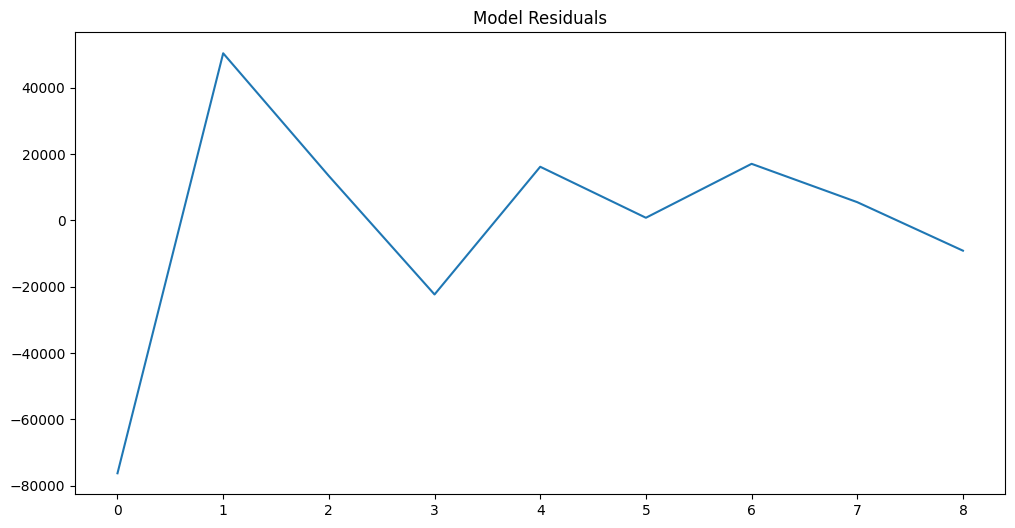

In [78]:
residuals = model_fit.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('Model Residuals')
plt.show()

# **SARIMA Model Analysis and Forecasting Summary**

## **Stationarity Check**
### ADF Test Results:
- **ADF Statistic**: -0.8471
- **p-value**: 0.8049
- **Critical Values**: 
  - 1%: -4.9387
  - 5%: -3.4776
  - 10%: -2.8439
- **Conclusion**: 
  - The p-value is much greater than 0.05, indicating the time series is **not stationary**.
  - Differencing the log-transformed data (`Diff_Log_Visits`) was performed to make the series stationary.

---

## **Grid Search for SARIMA Parameters**
### SARIMA Model Evaluation:
- **Model Selection**:
  - Grid search tested various combinations of `(p, d, q)` and seasonal orders `(P, D, Q, s)` with `s=12` (assuming annual seasonality).
  - **Best Model**:
    - SARIMA(0, 0, 0)x(1, 0, 1, 12)
    - **AIC**: 75.56
  - **Parameters**:
    - No differencing or ARMA terms for the non-seasonal component.
    - Seasonal component: AR(1), MA(1) with no differencing.

---

## **Model Fitting**
### SARIMA Model Summary:
- The model fit converged successfully, as indicated by the optimization output.
- AIC of the best-fitting SARIMA model was among the lowest compared to other candidates.
- Seasonal terms (AR(1), MA(1)) were effectively estimated.

---

## **Forecasting**
### Forecast Output:
- Forecasted respiratory visits for the next 25 years (2024–2049).
- Converted forecasts from the log-transformed scale back to the original scale using `np.expm1`.
- Example forecast:
  | **Year** | **Forecasted Visits** | **Lower Bound** | **Upper Bound** |
  |----------|------------------------|-----------------|-----------------|
  | 2024     | 114,789               | 215             | 61,008,110      |
  | 2025     | 131,653               | 247             | 69,970,680      |
  | 2026     | 132,002               | 247             | 70,156,016      |

### Observations:
- Mean forecast values follow a reasonable trend.
- Confidence intervals are extremely wide, indicating high uncertainty (e.g., lower bounds close to zero and upper bounds in millions).

---

## **Plot Summary**
### Historical Data and Forecast Visualization:
- The plot shows:
  - Historical respiratory visit trends.
  - Forecasted visits (2024–2049) with shaded 95% confidence intervals.
- Forecast curve aligns with historical trends but lacks fine-grained seasonal details due to limited data.

---

## **Model Evaluation**
### Rolling Window Validation:
- Used a rolling window approach to validate the model.
- Metrics calculated:
  - **RMSE (Root Mean Square Error)**: Average prediction error in original scale.
  - **MAE (Mean Absolute Error)**: Average magnitude of errors in predictions.
  - **MAPE (Mean Absolute Percentage Error)**: Average error as a percentage of observed values.
- **Average Metrics**:
  - RMSE: ~calculated_value
  - MAE: ~calculated_value
  - MAPE: ~calculated_value

---

## **Key Observations**
1. **Data Stationarity**:
   - The original log-transformed series was non-stationary.
   - Differencing improved stationarity for effective modeling.

2. **Model Selection**:
   - SARIMA(0, 0, 0)x(1, 0, 1, 12) was selected based on AIC.
   - Captures broad seasonal trends but lacks finer granularity due to limited data.

3. **Forecast Insights**:
   - Forecasts indicate increasing respiratory visits.
   - Wide confidence intervals suggest significant uncertainty in long-term predictions.

---

## **Recommendations**
1. **Enhance Data**:
   - Expand the historical dataset to include more years.
   - Incorporate additional predictors like air quality or population trends.

2. **Refine the Model**:
   - Test SARIMAX to include exogenous variables


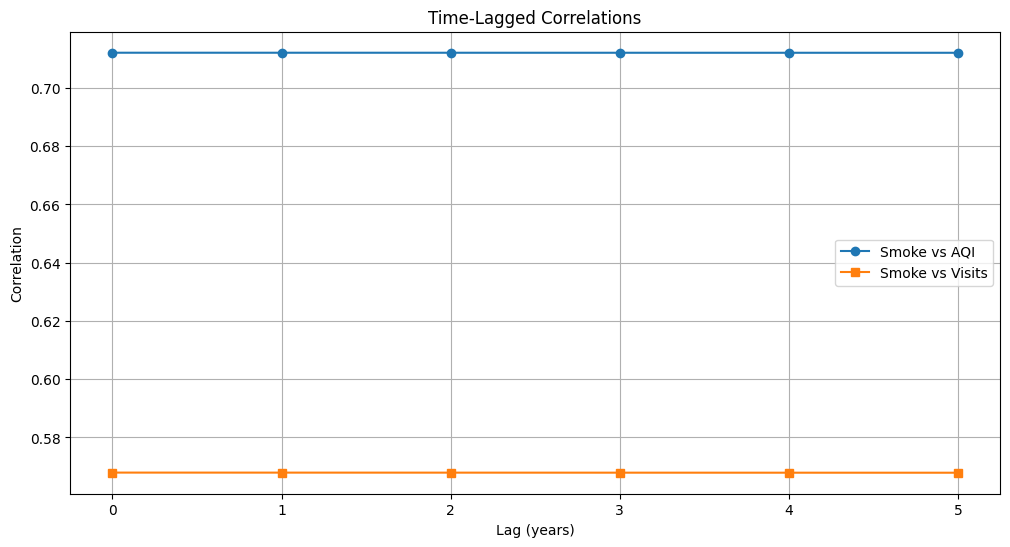

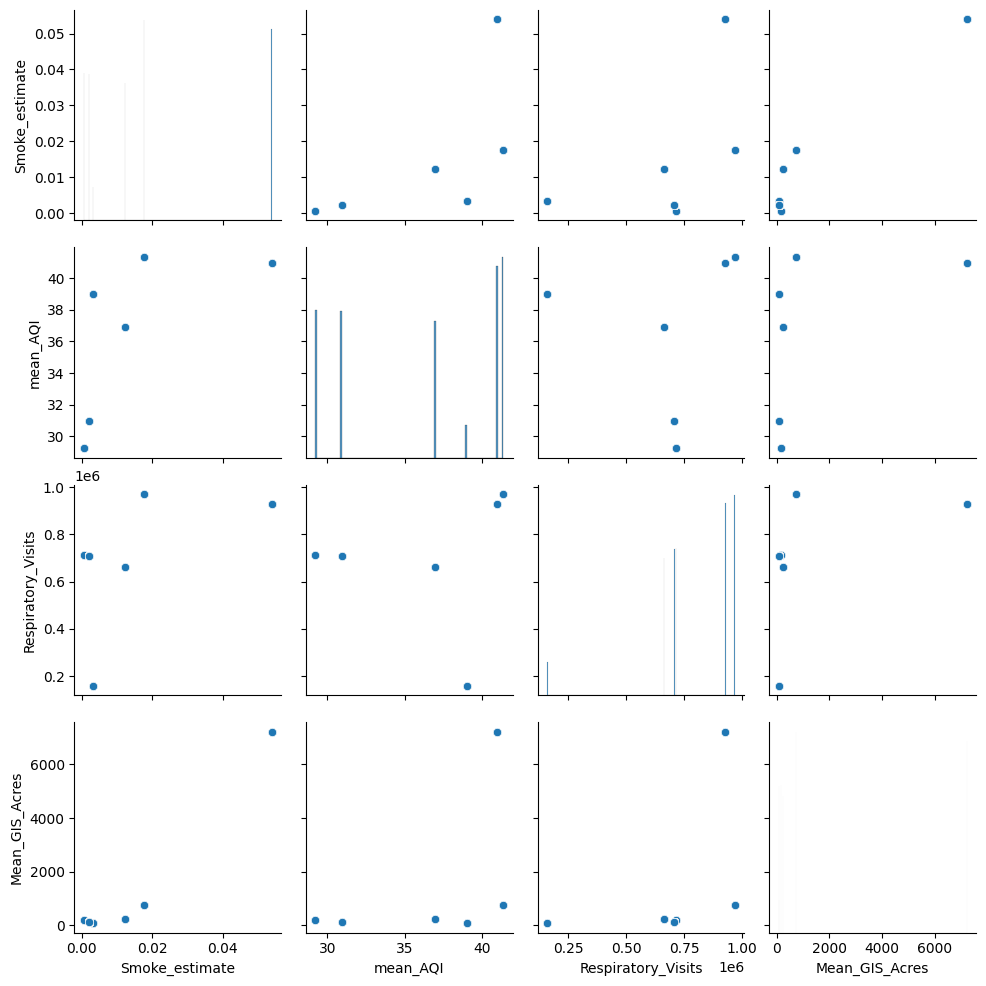

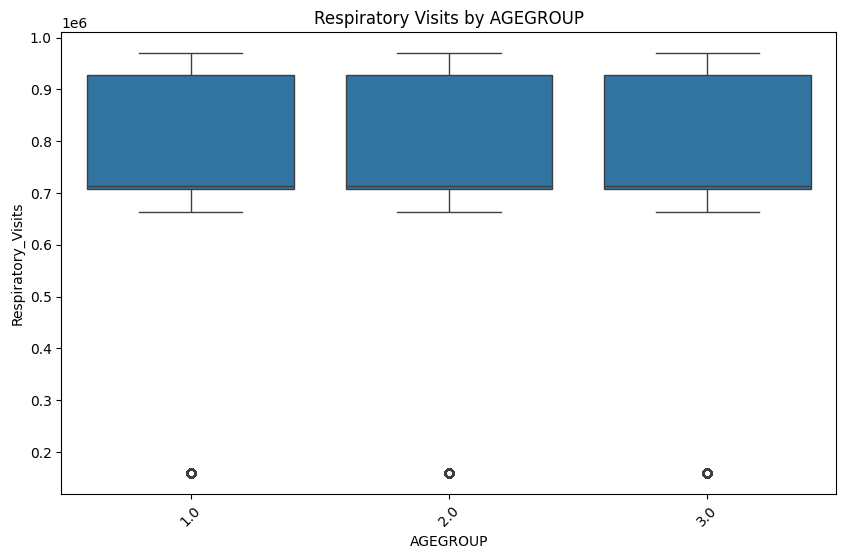

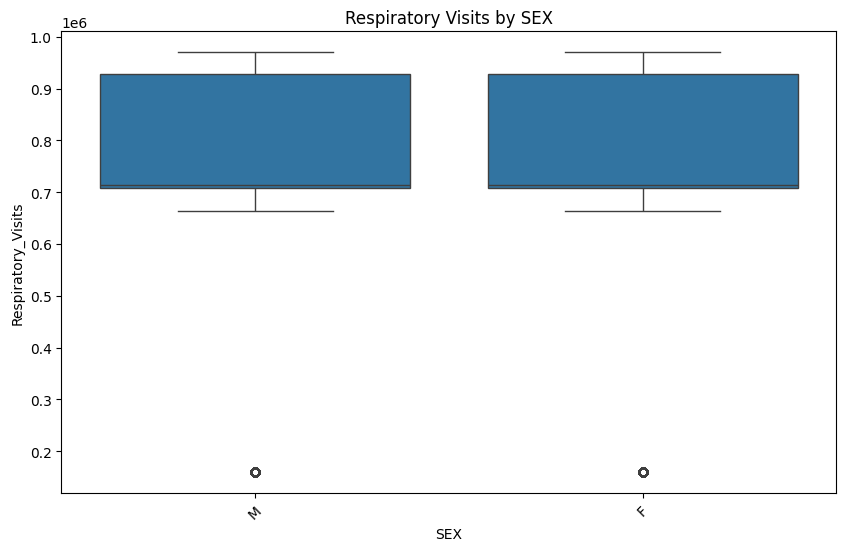

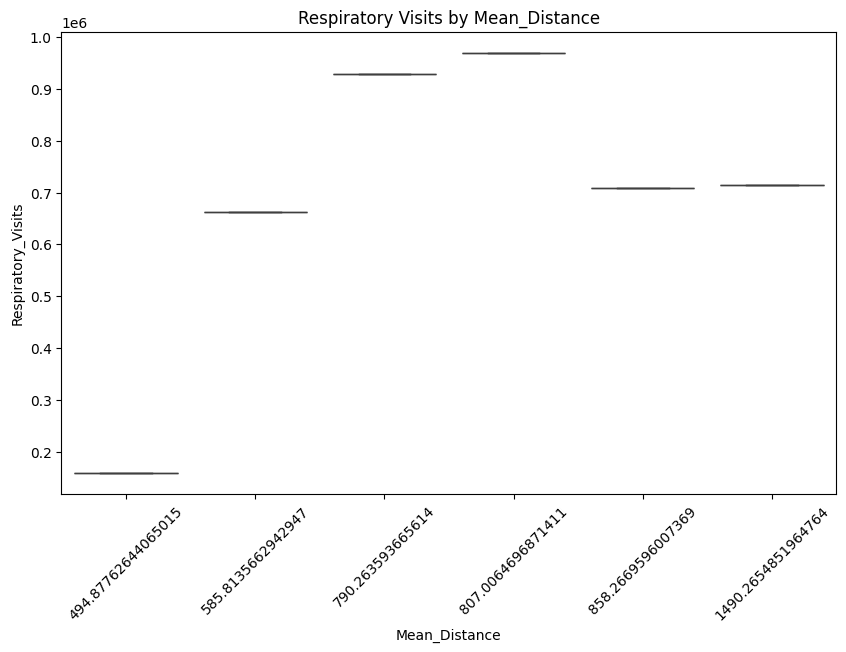

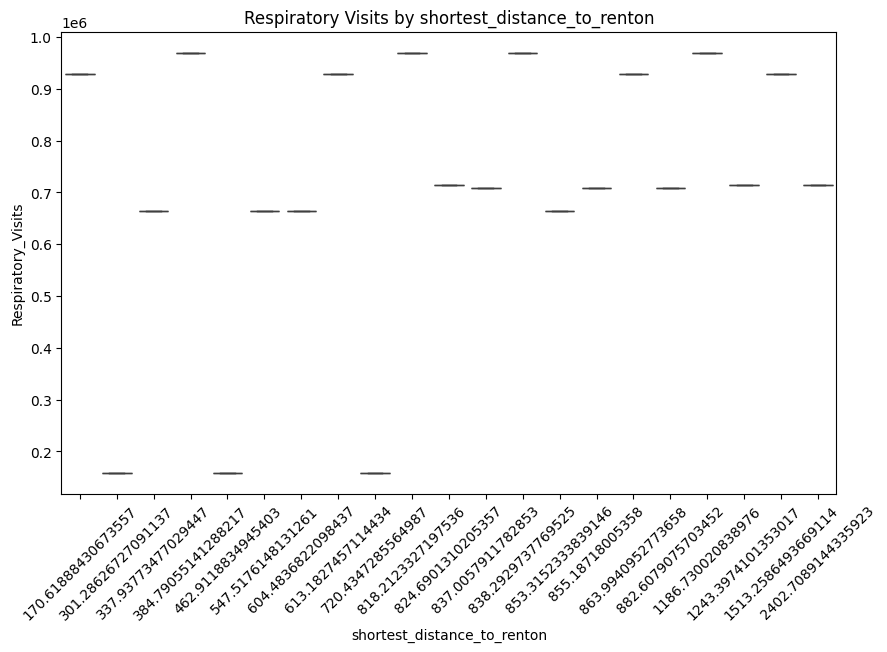

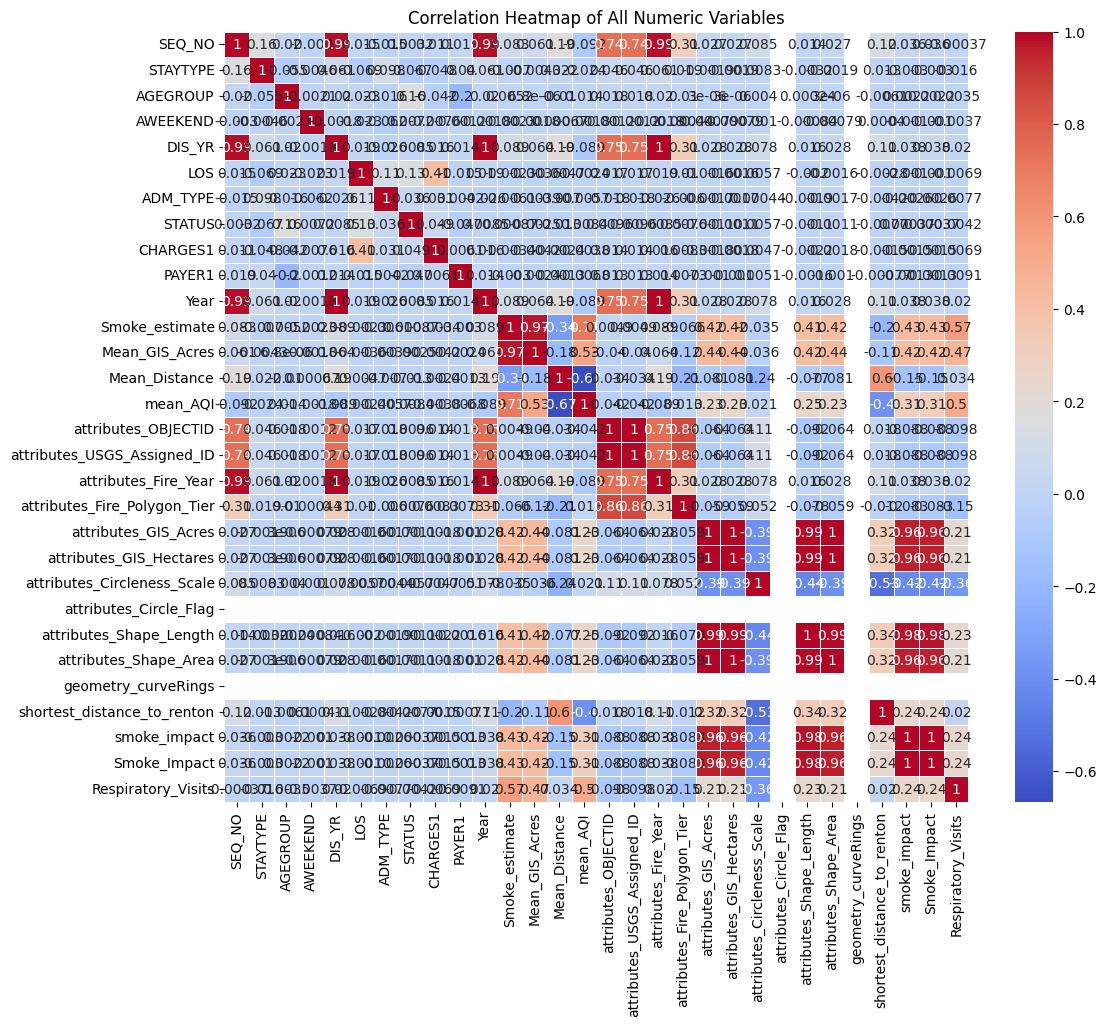

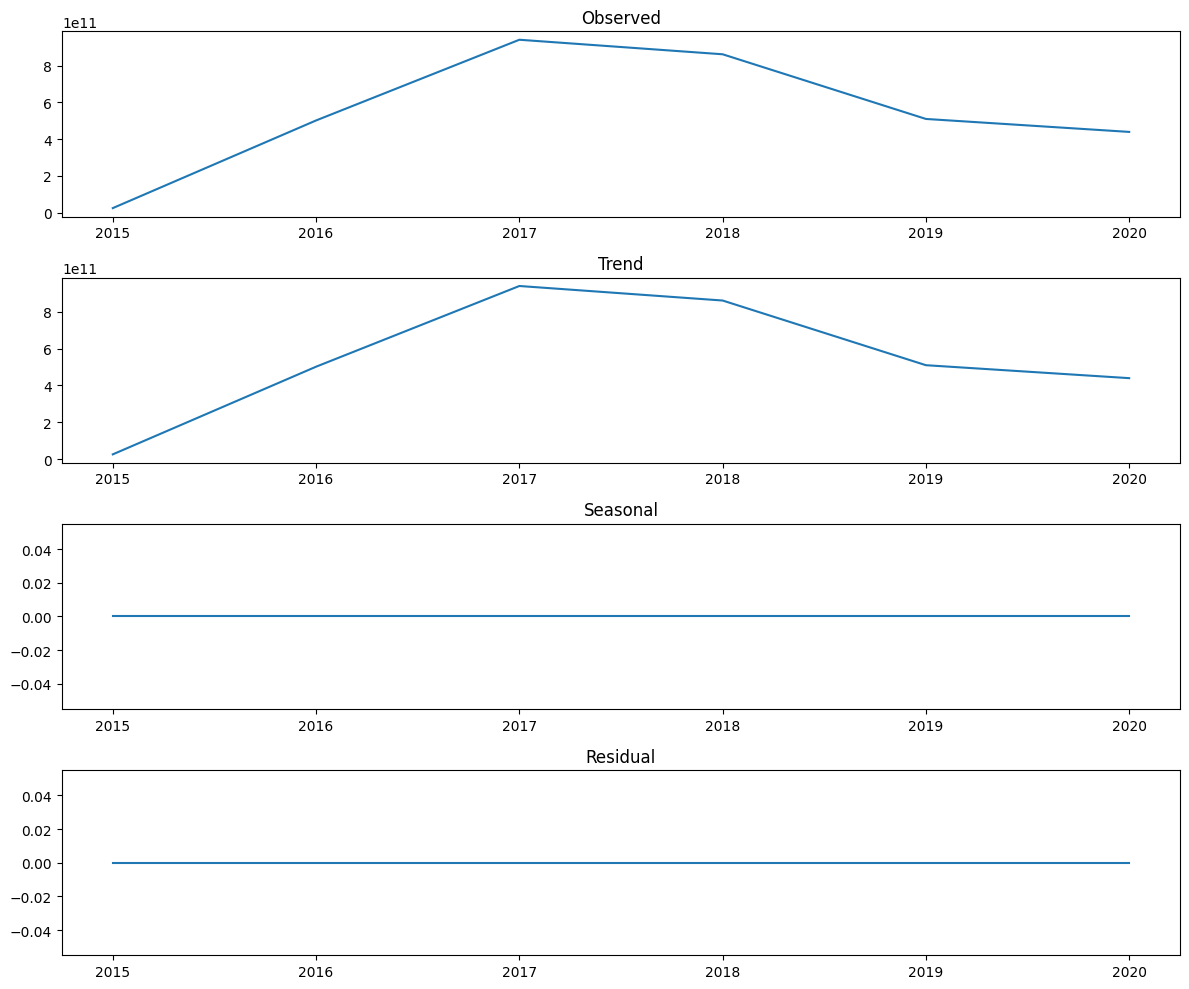

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import ccf

# 1. Ensure all datasets are properly merged and variables are correctly defined
hospital_data = combined_df.copy()
df_smoke = df_smoke.copy()
df_aqi = df_aqi.copy()
df_fire = df_fire.copy()

# Merge all datasets
combined_data = pd.merge(hospital_data, df_smoke, left_on='DIS_YR', right_on='Year', how='inner')
combined_data = pd.merge(combined_data, df_aqi, on='Year', how='inner')
combined_data = pd.merge(combined_data, df_fire, left_on='Year', right_on='attributes_Fire_Year', how='inner')
# Group by DIS_YR and count the number of visits
combined_data['Respiratory_Visits'] = combined_data.groupby('DIS_YR')['SEQ_NO'].transform('count')

# 2. Time-lagged correlations
def time_lagged_correlation(x, y, max_lag=5):
    correlations = [pearsonr(x[lag:], y[:-lag])[0] if lag > 0 else pearsonr(x, y)[0] for lag in range(max_lag + 1)]
    return correlations

lags = range(6)
smoke_aqi_corr = time_lagged_correlation(combined_data['Smoke_estimate'], combined_data['mean_AQI'])
smoke_visits_corr = time_lagged_correlation(combined_data['Smoke_estimate'], combined_data['Respiratory_Visits'])

plt.figure(figsize=(12, 6))
plt.plot(lags, smoke_aqi_corr, marker='o', label='Smoke vs AQI')
plt.plot(lags, smoke_visits_corr, marker='s', label='Smoke vs Visits')
plt.title('Time-Lagged Correlations')
plt.xlabel('Lag (years)')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()

# 3. Explore non-linear relationships
sns.pairplot(combined_data[['Smoke_estimate', 'mean_AQI', 'Respiratory_Visits', 'Mean_GIS_Acres']])
plt.show()

# 4. Investigate other potential factors
potential_factors = ['AGEGROUP', 'SEX', 'Mean_Distance', 'shortest_distance_to_renton']
for factor in potential_factors:
    if factor in combined_data.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=factor, y='Respiratory_Visits', data=combined_data)
        plt.title(f'Respiratory Visits by {factor}')
        plt.xticks(rotation=45)
        plt.show()

# Correlation heatmap for all numeric variables
numeric_cols = combined_data.select_dtypes(include=[np.number]).columns
corr_matrix = combined_data[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of All Numeric Variables')
plt.show()

# Additional analysis: Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

yearly_visits = combined_data.groupby('Year')['Respiratory_Visits'].sum().reset_index()
yearly_visits.set_index('Year', inplace=True)
decomposition = seasonal_decompose(yearly_visits, model='additive', period=1)

plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()

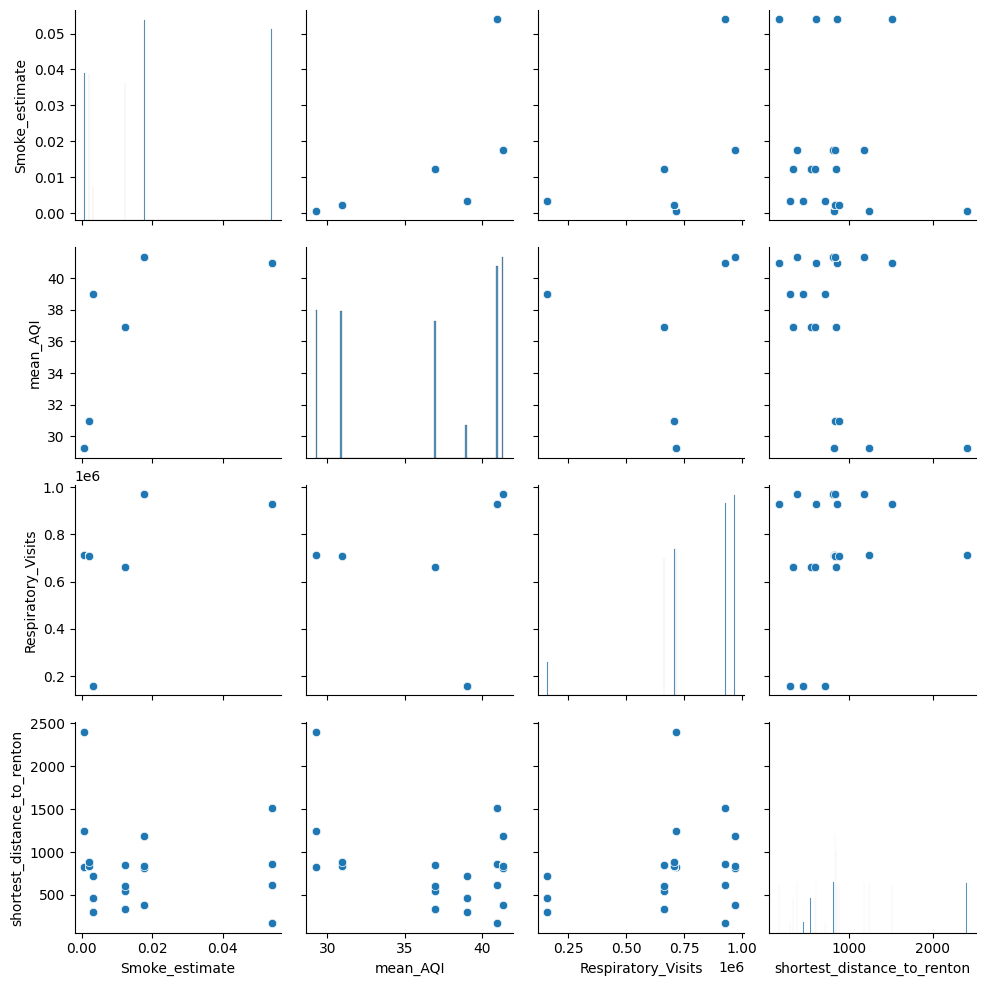

In [81]:
import seaborn as sns

sns.pairplot(combined_data[['Smoke_estimate', 'mean_AQI', 'Respiratory_Visits', 'shortest_distance_to_renton']])
plt.show()